# Task 2 - Small Object Detection Strategy

Since tiny objects are lost when we use models like YOLO

We will use slicing approach

1.   We will devide the 4k image into smaller size images (ex:640x640)  

2.   Then we overlap those images by some percentage as shown in the figure below (each box represent one of the smaller images)

3.  This overlapping regions will help in case we had some screws that was split at the edge so it will prevent them from not being taken into consideration

4.  What about if screws are counted more than once (they appear fully in the intersecting region of 2 images so they are counted twice)? We will store the coodrinates of all screws detected so if it is detected twice we can show it only once

Regarding running a model on a Raspberry-pi using such values will be take so much computational power so we can:


*   Make the tile image dimentions larger so few tiles
*   Reducing overlap percentage



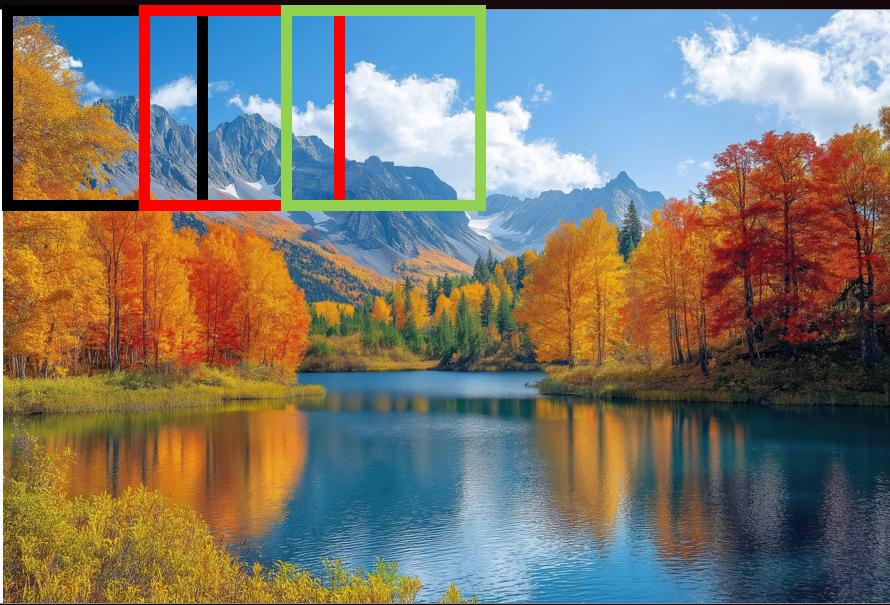

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install kaggle

In [4]:
!kaggle datasets download -d wjybuqi/screwwasher-dataset-for-small-object-detection

Dataset URL: https://www.kaggle.com/datasets/wjybuqi/screwwasher-dataset-for-small-object-detection
License(s): copyright-authors
 96% 605M/632M [00:01<00:00, 307MB/s]
100% 632M/632M [00:01<00:00, 387MB/s]


In [8]:
!unzip screwwasher-dataset-for-small-object-detection.zip -d screwdrivers

Archive:  screwwasher-dataset-for-small-object-detection.zip
  inflating: screwdrivers/0.7_b1_Color.png  
  inflating: screwdrivers/0.7_b2_Color.png  
  inflating: screwdrivers/0.7_b3_Color.png  
  inflating: screwdrivers/0.7_b4_Color.png  
  inflating: screwdrivers/0.7_c1_Color.png  
  inflating: screwdrivers/0.7_c2_Color.png  
  inflating: screwdrivers/0.7_c3_Color.png  
  inflating: screwdrivers/0.7_c4_Color.png  
  inflating: screwdrivers/0.7_g1_Color.png  
  inflating: screwdrivers/0.7_g2_Color.png  
  inflating: screwdrivers/0.7_g3_Color.png  
  inflating: screwdrivers/0.7_g4_Color.png  
  inflating: screwdrivers/0.7_p1_Color.png  
  inflating: screwdrivers/0.7_p2_Color.png  
  inflating: screwdrivers/0.7_p3_Color.png  
  inflating: screwdrivers/0.7_p4_Color.png  
  inflating: screwdrivers/0.7_w1_Color.png  
  inflating: screwdrivers/0.7_w2_Color.png  
  inflating: screwdrivers/0.7_w3_Color.png  
  inflating: screwdrivers/0.7_w4_Color.png  
  inflating: screwdrivers/0.8_c1_Color.

In [10]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.8 MB/s eta 0:00:00


In [12]:
import cv2
import numpy as np
from ultralytics import YOLO
from matplotlib import pyplot as plt

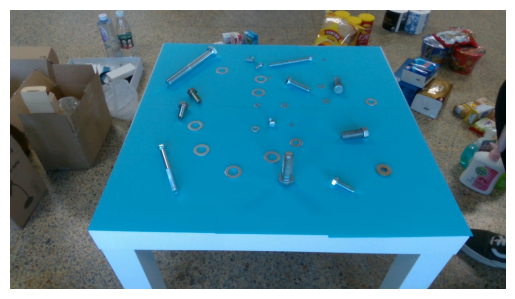

In [16]:
img = cv2.imread('/content/screwdrivers/0.7_b1_Color.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
def tile_image(image, tile_dim, overlap):
    # Dividing shapes into tiles and overlapping those tiles
    h, w, _ = image.shape
    stride = int(tile_dim * (1 - overlap))
    tiles = []

    for y in range(0, h, stride):
        for x in range(0, w, stride):
            x_end = min(x + tile_dim, w)
            y_end = min(y + tile_dim, h)
            tile = image[y:y_end, x:x_end]
            tiles.append((tile, x, y))
    return tiles


In [ ]:
def detect_tiles(image, model, tile_dim, overlap, conf_threshold):
    # Detecting objects in each tile
    tiles = tile_image(image, tile_dim, overlap)
    all_boxes = []

    for tile, x_offset, y_offset in tiles:
        results = model(tile)
        for r in results:
            for box in r.boxes:
                conf = float(box.conf)
                if conf < conf_threshold:
                    continue
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                all_boxes.append([x1 + x_offset, y1 + y_offset, x2 + x_offset, y2 + y_offset, conf])
    return np.array(all_boxes)


In [ ]:
def unique_boxes(boxes, intersction_threshold):
    # Making sure each box is only present once by checking that the intersection between boxes is less than a certain threshold
    if len(boxes) == 0:
        return []

    boxes = boxes[boxes[:,4].argsort()[::-1]]
    keep = []

    while len(boxes) > 0:
        keep.append(boxes[0])
        if len(boxes) == 1:
            break
        ious = compute_collisions(boxes[0], boxes[1:])
        boxes = boxes[1:][ious < intersction_threshold]
    return np.array(keep)

def compute_collisions(box, others):
    x1 = np.maximum(box[0], others[:,0])
    y1 = np.maximum(box[1], others[:,1])
    x2 = np.minimum(box[2], others[:,2])
    y2 = np.minimum(box[3], others[:,3])

    inter_area = np.maximum(0, x2 - x1) * np.maximum(0, y2 - y1)
    box_area = (box[2]-box[0])*(box[3]-box[1])
    others_area = (others[:,2]-others[:,0])*(others[:,3]-others[:,1])

    iou = inter_area / (box_area + others_area - inter_area + 1e-6)
    return iou


In [24]:
# YOLO doesnt have a screws class so it will not detect the screws but if the model is replaced with a fine tuned model that does it will work perfectly
model = YOLO("yolov8n.pt")

boxes = detect_tiles(img, model, 512, 0.2, 0.3)

final_boxes = unique_boxes(boxes, 0.5)

for x1, y1, x2, y2, conf in final_boxes:
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), 2)
    cv2.putText(img, f"{conf:.2f}", (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

cv2.imwrite("output_detected.jpg", img)
print("Detected screws:", len(final_boxes))



0: 640x640 (no detections), 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 3.9ms preprocess, 7.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 3.3ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 bottle, 1 cup, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x384 (no detections), 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x640 (no detections), 8.3ms
Speed: 3.9ms preprocess, 8.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 7.7ms
Speed: 3.6ms preprocess, 7.7ms inference, 0.8ms 